In [1]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from numpy.linalg import cond, matrix_rank, norm
from scipy.linalg import inv, solve, det, eig, lu, eigvals
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.svar_model import SVAR
import warnings
warnings.filterwarnings("ignore")
from pandas.plotting import table

In [2]:
#importing data
BL = pd.read_csv('Data/BankLend.csv')
consumption = pd.read_csv('Data/consumption 2.csv')
gdp_exp = pd.read_csv('Data/gdp.csv')
housing_starts = pd.read_csv('Data/HousingStarts.csv')
ex_rate = pd.read_csv('Data/CEER_MONTHLY_NOMINAL-sd-1990-01-01.csv') #Canadian Effective Exchange Rate - monthly nominal
SP_tbills = pd.read_csv('Data/s&p, tbills.csv')
house_prices = pd.read_csv('Data/OECD Data.csv')

In [3]:
# BANK LENDING

# Summing over rows of 3 to get quarterly data
def sum_quarter(group):
    return pd.Series({'ReferencePeriod': group['ReferencePeriod'].iloc[0],
                      'Total, funds advanced, residential mortgages, insured 7': group['Total, funds advanced, residential mortgages, insured 7'].sum(),
                      'Total, funds advanced, residential mortgages, uninsured 7': group['Total, funds advanced, residential mortgages, uninsured 7'].sum(),
                      'Total, funds advanced, variable rate mortgages': group['Total, funds advanced, variable rate mortgages'].sum(),
                      'Total, funds advanced for non-mortgage loans, consumer credit': group['Total, funds advanced for non-mortgage loans, consumer credit'].sum(),
                      'Total, funds advanced, business loans 8': group['Total, funds advanced, business loans 8'].sum()})

# Group by sets of 3 rows and average using the custom function
BankLend = BL.groupby(BL.index // 3).apply(sum_quarter)
BankLend['ReferencePeriod'] = pd.to_datetime(BankLend['ReferencePeriod'])
BankLend['Quarters'] = BankLend['ReferencePeriod'].dt.to_period("Q").astype(str)

# cleaning up the data
BankLend['BankLending'] = BankLend['Total, funds advanced, residential mortgages, insured 7'] + BankLend['Total, funds advanced, residential mortgages, uninsured 7'] +  BankLend['Total, funds advanced, variable rate mortgages'] + BankLend['Total, funds advanced for non-mortgage loans, consumer credit'] + BankLend['Total, funds advanced, business loans 8'] + BankLend['Total, funds advanced, business loans 8']
BankLend1 = BankLend[['Quarters','BankLending']]
BankLend1.head()

,Quarters,BankLending
0,2013Q1,382924.0
1,2013Q2,493784.0
2,2013Q3,483018.0
3,2013Q4,503383.0
4,2014Q1,420139.0


In [4]:
# GDP 

# keeping specific columns
gdp = gdp_exp[['Quarters', 'Gross domestic product at market prices']]

gdp.head()

,Quarters,Gross domestic product at market prices
0,2000Q1,1514676
1,2000Q2,1532503
2,2000Q3,1548212
3,2000Q4,1551274
4,2001Q1,1560006


In [5]:
# EXCHANGE RATE

# keeping one column
filtered_ex_rate = ex_rate[['date','CEER_BROADNM']]
filtered_ceer = filtered_ex_rate.reset_index(drop=True)

# Averaging over rows of 3 to get quarterly data
def average_quarter(group):
    return pd.Series({'date': group['date'].iloc[0],
                      'CEER_BROADNM': group['CEER_BROADNM'].mean()})

# Group by sets of 3 rows and average using the custom function
ceer = filtered_ceer.groupby(filtered_ceer.index // 3).apply(average_quarter).reset_index(drop=True)

# converting date to datetime format
ceer['date'] = pd.to_datetime(ceer['date'])
ceer['Quarters'] = ceer['date'].dt.to_period("Q").astype(str)

ceer = ceer.drop(['date'], axis=1)
ceer.head()

,CEER_BROADNM,Quarters
0,98.053333,1999Q1
1,101.366667,1999Q2
2,100.096667,1999Q3
3,100.486667,1999Q4
4,102.433333,2000Q1


In [6]:
# CONSUMPTION, HOUSE PRICES, HOUSING STARTS

print(consumption.head())
print(house_prices.head())
print(housing_starts.head())

  Quarters  Household final consumption expenditure
0   2000Q1                                   143884
1   2000Q2                                   145903
2   2000Q3                                   148957
3   2000Q4                                   150284
4   2001Q1                                   151594
  Quarters  House_Prices
0   2001Q1     40.844646
1   2001Q2     41.200980
2   2001Q3     41.875943
3   2001Q4     42.620664
4   2002Q1     43.340875
  Quarters  HousingStarts
0   2016Q1          38175
1   2016Q2          53286
2   2016Q3          54899
3   2016Q4          51555
4   2017Q1          42862


In [7]:
# FINANCIAL INDICATORS: S&P 500, T-BILLS

# Averaging over rows of 3 to get quarterly data
def average_quarter(group):
    return pd.Series({'nummonth': group['nummonth'].iloc[0],
                      'sp': group['sp'].mean(), 't_bills': group['t_bills'].mean()})

# Group by sets of 3 rows and average using the custom function
fin_ind = SP_tbills.groupby(SP_tbills.index // 3).apply(average_quarter).reset_index(drop=True)
fin_ind.rename(columns={'nummonth': 'Quarters'}, inplace=True)
fin_ind.head()

,Quarters,sp,t_bills
0,2013Q1,36782.440000,0.953333
1,2013Q2,36089.766667,1.010000
2,2013Q3,37059.500000,0.990000
3,2013Q4,39750.513333,0.916667
4,2014Q1,41900.943333,0.876667


In [8]:
merge1 = pd.merge(gdp, consumption, on = 'Quarters')
merge2 = pd.merge(merge1, BankLend1, on = 'Quarters')
merge3 = pd.merge(merge2, ceer, on = 'Quarters')
merge4 = pd.merge(merge3, house_prices, on = 'Quarters')
merge5 = pd.merge(merge4, housing_starts, on = 'Quarters')
final_merge = pd.merge(merge5, fin_ind, on = 'Quarters')
final_merge.rename(columns={'Gross domestic product at market prices': 'GDP', 'Household final consumption expenditure': 'CON', 'BankLending': 'BL',
                         'CEER_BROADNM':'FX', 'House_Prices': 'HP', 'HousingStarts': 'HI', 'sp':'OMX', 't_bills':'IR'}, inplace=True)
final_merge.head()

,Quarters,GDP,CON,BL,FX,HP,HI,OMX,IR
0,2016Q1,2071732,285296,495823.0,111.046667,105.128205,38175,41244.963333,0.460000
1,2016Q2,2061412,286760,579799.0,117.166667,108.601056,53286,44654.566667,0.523333
2,2016Q3,2082805,289033,586583.0,116.170000,112.826169,54899,46931.136667,0.516667
3,2016Q4,2094490,292579,575781.0,115.810000,115.803167,51555,48612.290000,0.493333
4,2017Q1,2120843,296967,539456.0,117.380000,119.193062,42862,50214.126667,0.486667


In [9]:
# Reorder the columns in line with paper
final_df = final_merge[['Quarters', 'GDP', 'CON', 'HI', 'HP', 'OMX', 'BL', 'FX', 'IR']]
final_df.head()

,Quarters,GDP,CON,HI,HP,OMX,BL,FX,IR
0,2016Q1,2071732,285296,38175,105.128205,41244.963333,495823.0,111.046667,0.460000
1,2016Q2,2061412,286760,53286,108.601056,44654.566667,579799.0,117.166667,0.523333
2,2016Q3,2082805,289033,54899,112.826169,46931.136667,586583.0,116.170000,0.516667
3,2016Q4,2094490,292579,51555,115.803167,48612.290000,575781.0,115.810000,0.493333
4,2017Q1,2120843,296967,42862,119.193062,50214.126667,539456.0,117.380000,0.486667


In [10]:
final_df['Quarters'] = pd.to_datetime(final_df['Quarters'])
final_df.head()
final_df.dtypes

# Convert to float
final_df['GDP'] = final_df['GDP'].astype(int)

# Convert to int
final_df['HI'] = final_df['HI'].astype(int)

final_df.head()

,Quarters,GDP,CON,HI,HP,OMX,BL,FX,IR
0,2016-01-01,2071732,285296,38175,105.128205,41244.963333,495823.0,111.046667,0.460000
1,2016-04-01,2061412,286760,53286,108.601056,44654.566667,579799.0,117.166667,0.523333
2,2016-07-01,2082805,289033,54899,112.826169,46931.136667,586583.0,116.170000,0.516667
3,2016-10-01,2094490,292579,51555,115.803167,48612.290000,575781.0,115.810000,0.493333
4,2017-01-01,2120843,296967,42862,119.193062,50214.126667,539456.0,117.380000,0.486667


In [11]:
# List of columns to calculate log difference
columns = ['GDP', 'CON', 'HI', 'HP', 'OMX', 'BL', 'FX', 'IR']

# Calculate log difference
for col in columns:
    final_df[col] = np.log(final_df[col]).diff()

# Print the DataFrame
final_df.head()
final_df = final_df.dropna()

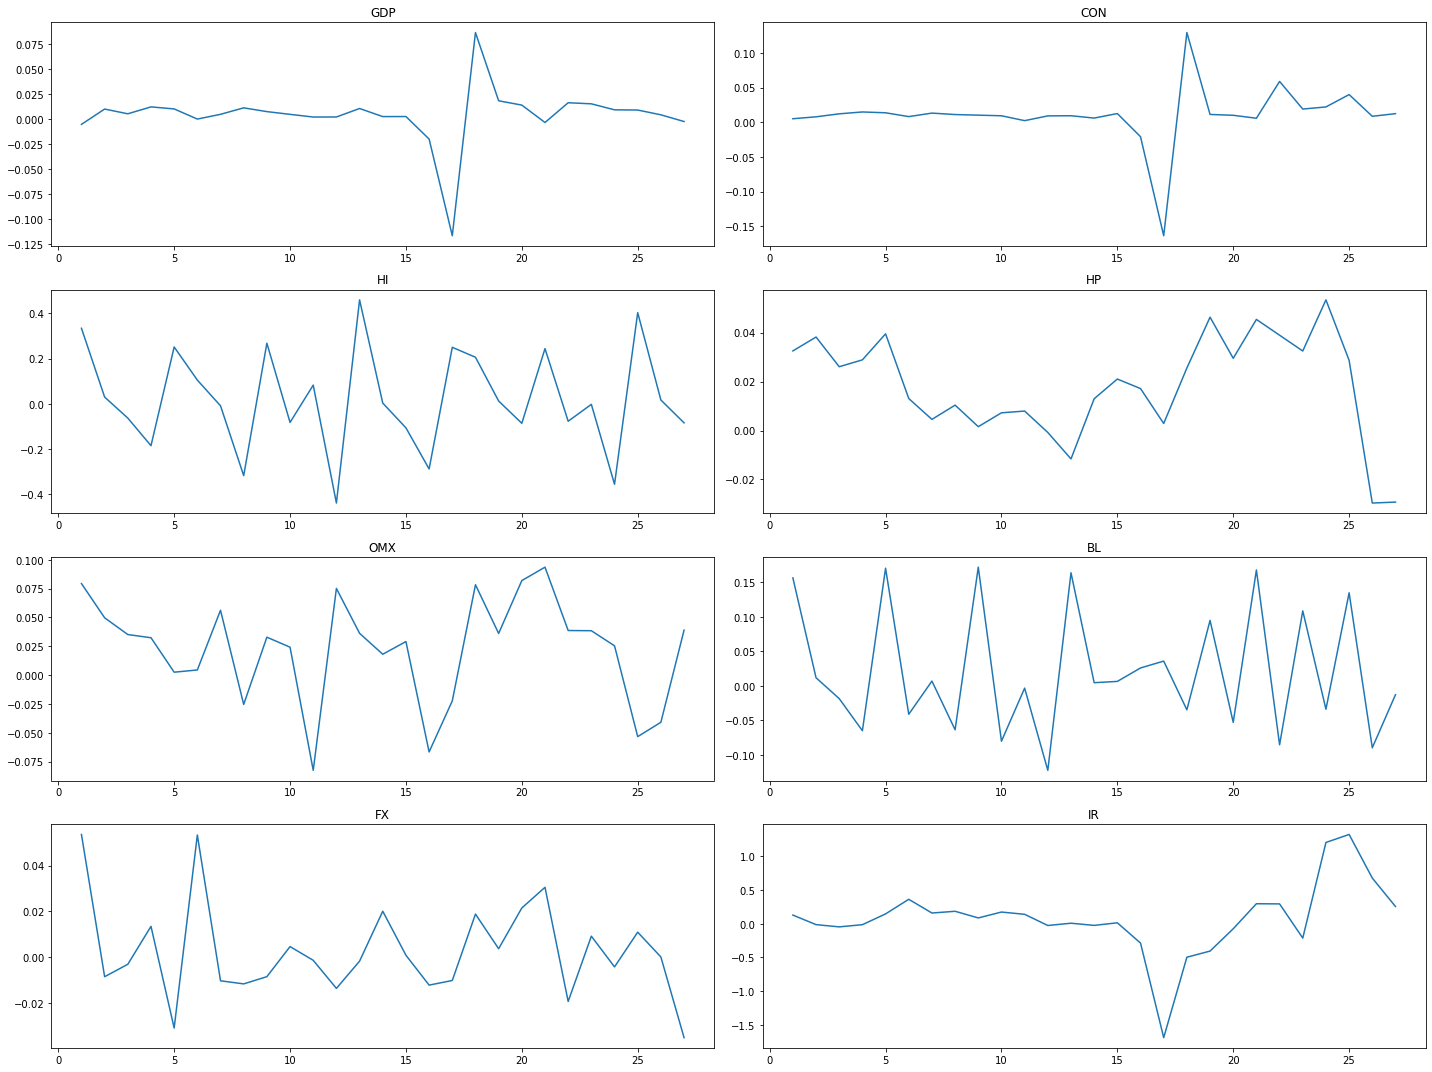

In [12]:
# List of columns to plot LOG DIFFERENCE
columns = ['GDP', 'CON', 'HI', 'HP', 'OMX', 'BL', 'FX', 'IR']

# Create a 4x2 grid of subplots
fig, axs = plt.subplots(4, 2, figsize=(20, 15))

# Flatten the axes array
axs = axs.flatten()

# Plot each column
for i, col in enumerate(columns):
    axs[i].plot(final_df[col])
    axs[i].set_title(col)

# Show the plot
plt.tight_layout()
plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller, kpss

def significance_marker(p_value):
    if p_value < 0.01:
        return '***'
    elif p_value < 0.05:
        return '**'
    elif p_value < 0.1:
        return '*'
    else:
        return ''

results_df = pd.DataFrame()

for col in columns:
    adf_result = adfuller(final_df[col].dropna())
    kpss_result = kpss(final_df[col].dropna())
    
    new_row = pd.DataFrame({
        'Variable': [col], 
        'ADF p-value': [format(adf_result[1], '.3f') + significance_marker(adf_result[1])],
        'KPSS p-value': [format(kpss_result[1], '.3f') + significance_marker(kpss_result[1])],
    })

    results_df = pd.concat([results_df, new_row], ignore_index=True)

# Print the results as a markdown table
print(results_df.to_markdown(index=False))


# Print the comment
print("\n***: p < 0.01, **: p < 0.05, *: p < 0.1")


| Variable   | ADF p-value   | KPSS p-value   |
|:-----------|:--------------|:---------------|
| GDP        | 0.000***      | 0.100          |
| CON        | 0.000***      | 0.100          |
| HI         | 0.620         | 0.042**        |
| HP         | 0.615         | 0.100          |
| OMX        | 0.002***      | 0.100          |
| BL         | 0.000***      | 0.100          |
| FX         | 0.000***      | 0.100          |
| IR         | 0.081*        | 0.100          |

***: p < 0.01, **: p < 0.05, *: p < 0.1


In [14]:
# List of columns to calculate another difference
columns = ['HI', 'HP', 'IR']

# Calculate another difference
for col in columns:
    final_df[col] = final_df[col].diff()

# Drop NA values
final_df = final_df.dropna()

# Print the DataFrame
final_df.head()


,Quarters,GDP,CON,HI,HP,OMX,BL,FX,IR
2,2016-07-01,0.010324,0.007895,-0.303671,0.005667,0.049725,0.011633,-0.008543,-0.141813
3,2016-10-01,0.005595,0.012194,-0.092667,-0.012124,0.035195,-0.018587,-0.003104,-0.033392
4,2017-01-01,0.012504,0.014886,-0.121818,0.002809,0.032420,-0.065166,0.013466,0.032607
5,2017-04-01,0.010471,0.013695,0.435555,0.010630,0.002544,0.170521,-0.030974,0.159898
6,2017-07-01,0.000314,0.008200,-0.146047,-0.026415,0.004470,-0.041307,0.053410,0.216871


In [15]:
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

def significance_marker(p_value):
    if p_value < 0.01:
        return '***'
    elif p_value < 0.05:
        return '**'
    elif p_value < 0.1:
        return '*'
    else:
        return ''

results_df = pd.DataFrame()

for col in columns:
    adf_result = adfuller(final_df[col].dropna())
    kpss_result = kpss(final_df[col].dropna())
    pp_test = PhillipsPerron(final_df[col].dropna())
    
    new_row = pd.DataFrame({
        'Variable': [col], 
        'ADF p-value': [format(adf_result[1], '.3f') + significance_marker(adf_result[1])],
        'KPSS p-value': [format(kpss_result[1], '.3f') + significance_marker(kpss_result[1])],
        'PP p-value': [format(pp_test.pvalue, '.3f') + significance_marker(pp_test.pvalue)]
    })

    results_df = pd.concat([results_df, new_row], ignore_index=True)

# Print the results as a markdown table
print(results_df.to_markdown(index=False))


# Print the comment
print("\n***: p < 0.01, **: p < 0.05, *: p < 0.1")


| Variable   | ADF p-value   |   KPSS p-value | PP p-value   |
|:-----------|:--------------|---------------:|:-------------|
| HI         | 0.000***      |            0.1 | 0.000***     |
| HP         | 0.602         |            0.1 | 0.000***     |
| IR         | 0.000***      |            0.1 | 0.000***     |

***: p < 0.01, **: p < 0.05, *: p < 0.1


In [16]:
# Convert DataFrame to NumPy array
endog_data = final_df[['GDP', 'CON', 'HI', 'HP', 'OMX', 'BL', 'FX', 'IR']].to_numpy()

# Impose Short-Term Restrictions for SVAR
B_matrix = np.array([
    [1, 'E', 'E', 0, 0, 0, 0, 0],
    [0, 1, 0, 'E', 'E', 'E', 0, 'E'],
    [0, 0, 1, 'E', 0,'E', 0, 'E'],
    [0, 0, 0, 1, 'E', 'E', 0, 'E'],
    [0, 0, 0, 0, 1, 'E', 'E', 'E'],
    [0, 0, 0, 0, 0, 1, 'E', 'E'],
    [0, 0, 0, 0, 0, 0, 1, 'E'],
    [0, 0, 0, 0, 0, 0, 0, 1],
])


# Define SVAR Model
svar_model = SVAR(endog=endog_data, svar_type='B', A=None, B=B_matrix, dates=final_df['Quarters'])

result = svar_model.fit()

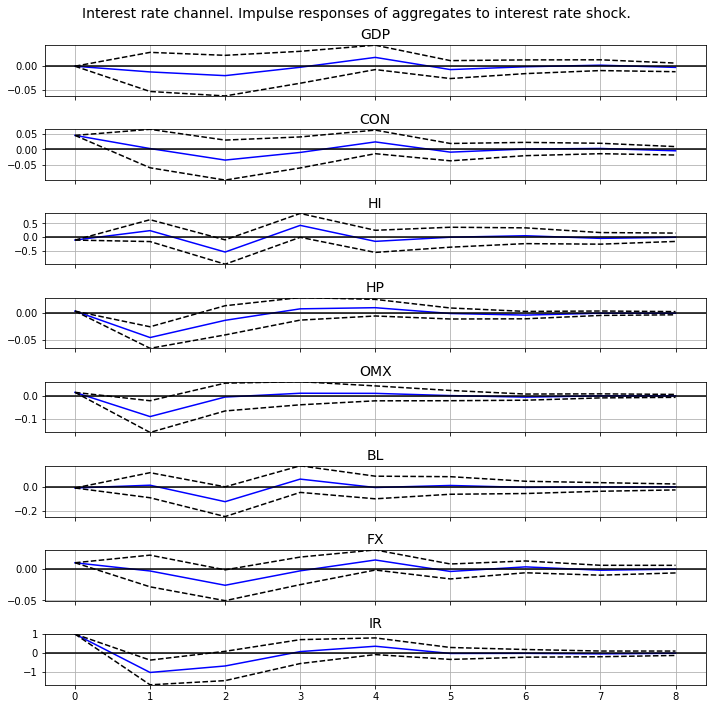

In [17]:
# Get the list of variable names in the model
var_names = ['GDP', 'CON', 'HI', 'HP', 'OMX', 'BL', 'FX', 'IR']

# Find the index of 't_bills' in this list
impulse_index = var_names.index('IR')

# Use this index for the impulse parameter
irf = result.irf(periods=8)# Convert DataFrame to NumPy array
endog_data = final_df[['GDP', 'CON', 'HI', 'HP', 'OMX', 'BL', 'FX', 'IR']].to_numpy()

# Impose Short-Term Restrictions for SVAR
B_matrix = np.array([
    [1, 'E', 'E', 0, 0, 0, 0, 0],
    [0, 1, 0, 'E', 'E', 'E', 0, 'E'],
    [0, 0, 1, 'E', 0,'E', 0, 'E'],
    [0, 0, 0, 1, 'E', 'E', 0, 'E'],
    [0, 0, 0, 0, 1, 'E', 'E', 'E'],
    [0, 0, 0, 0, 0, 1, 'E', 'E'],
    [0, 0, 0, 0, 0, 0, 1, 'E'],
    [0, 0, 0, 0, 0, 0, 0, 1],
])


# Define SVAR Model
svar_model = SVAR(endog=endog_data, svar_type='B', A=None, B=B_matrix, dates=final_df['Quarters'])

result = svar_model.fit()

# Create a figure with multiple subplots
fig = irf.plot(impulse=impulse_index, plot_stderr=True, subplot_params={'figsize': (10, 20)})

# Loop over the axes and set the title
for i, ax in enumerate(fig.axes):
    ax.set_title(f'{var_names[i]}', fontsize=14)
    ax.grid(True)
    ax.autoscale(enable=True, axis='y', tight=True)  # Automatically adjust y-axis limits

# Set the overall title
fig.suptitle('Interest rate channel. Impulse responses of aggregates to interest rate shock.', fontsize=14)

plt.tight_layout()
plt.show()

In [18]:
# Get the impulse responses for all periods
irfs = irf.irfs

# Convert the array into a DataFrame
df = pd.DataFrame(irfs[:, impulse_index, :], columns=var_names)

# Set the index to be the periods
df.index.name = 'Period'

# Display the DataFrame with a title
print("Interest rate channel. Impulse responses of aggregates to interest rate shock.")
display(df)

Interest rate channel. Impulse responses of aggregates to interest rate shock.


,GDP,CON,HI,HP,OMX,BL,FX,IR
Period,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,22.570347,-18.029061,0.558297,6.853613,5.338980,-1.518126,2.704315,-0.310948
2,16.789523,-8.601311,0.124972,1.529947,-0.734721,-1.869634,-2.279956,-0.281688
3,-7.190533,6.964033,0.157298,2.233922,-0.980822,-0.358768,0.816814,-0.227680
4,-7.985704,3.429049,-0.118136,-2.263478,-0.036478,0.297640,-0.946893,0.210917
5,1.784584,-1.500289,-0.181148,-1.077657,-0.275919,1.047447,1.006009,0.032778
6,1.250109,-0.106935,0.125213,0.916327,0.284549,-0.542604,-0.586122,-0.009238
7,0.342565,-0.715727,0.019810,0.227331,0.270472,-0.163074,0.335146,-0.023755
8,0.512558,-0.120988,-0.038653,-0.286901,-0.285255,0.171112,-0.174206,-0.004455


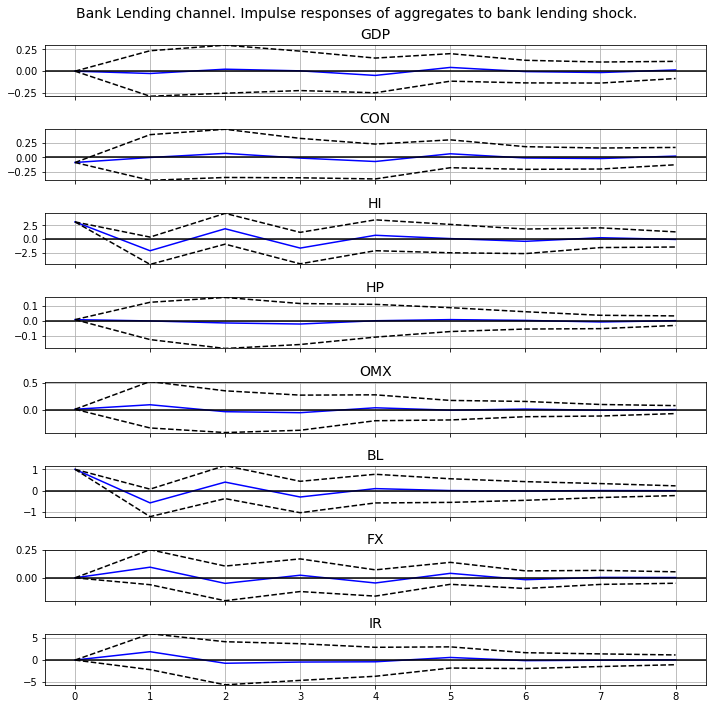

In [19]:
# Get the list of variable names in the model
var_names = ['GDP', 'CON', 'HI', 'HP', 'OMX', 'BL', 'FX', 'IR']

# Find the index of 't_bills' in this list
impulse_index = var_names.index('BL')

# Use this index for the impulse parameter
irf = result.irf(periods=8)

# Create a figure with multiple subplots
fig = irf.plot(impulse=impulse_index, plot_stderr=True, subplot_params={'figsize': (10, 20)})

# Loop over the axes and set the title
for i, ax in enumerate(fig.axes):
    ax.set_title(f'{var_names[i]}', fontsize=14)
    ax.grid(True)
    ax.autoscale(enable=True, axis='y', tight=True)  # Automatically adjust y-axis limits

# Set the overall title
fig.suptitle('Bank Lending channel. Impulse responses of aggregates to bank lending shock.', fontsize=14)

plt.tight_layout()
plt.show()

In [20]:
# Get the impulse responses for all periods
irfs = irf.irfs

# Convert the array into a DataFrame
df = pd.DataFrame(irfs[:, impulse_index, :], columns=var_names)

# Set the index to be the periods
df.index.name = 'Period'

# Display the DataFrame with a title
print("Bank Lending channel. Impulse responses of aggregates to interest rate shock.")
display(df)

Bank Lending channel. Impulse responses of aggregates to interest rate shock.


,GDP,CON,HI,HP,OMX,BL,FX,IR
Period,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
1,1.247486,-1.077640,0.057898,0.212071,0.460606,-0.850775,-0.874824,0.058504
2,1.592518,-0.912206,-0.026029,0.310082,-0.121849,0.403213,1.090070,-0.090024
3,-0.873496,0.878811,0.042558,-0.005485,-0.072953,-0.352286,-0.984766,0.034320
4,-0.487194,0.001816,-0.026996,-0.026343,0.057104,0.182934,0.657535,-0.014312
5,0.274376,-0.074998,-0.008608,-0.214129,-0.088025,0.029456,-0.360811,0.018584
6,-0.056509,0.052505,0.012939,0.200851,0.068632,-0.051567,0.180276,-0.010450
7,0.082881,-0.107869,-0.002411,-0.075858,0.000539,0.006139,-0.073646,0.003692
8,0.040981,0.012512,-0.002522,0.014424,-0.022971,0.008687,0.022949,-0.002567


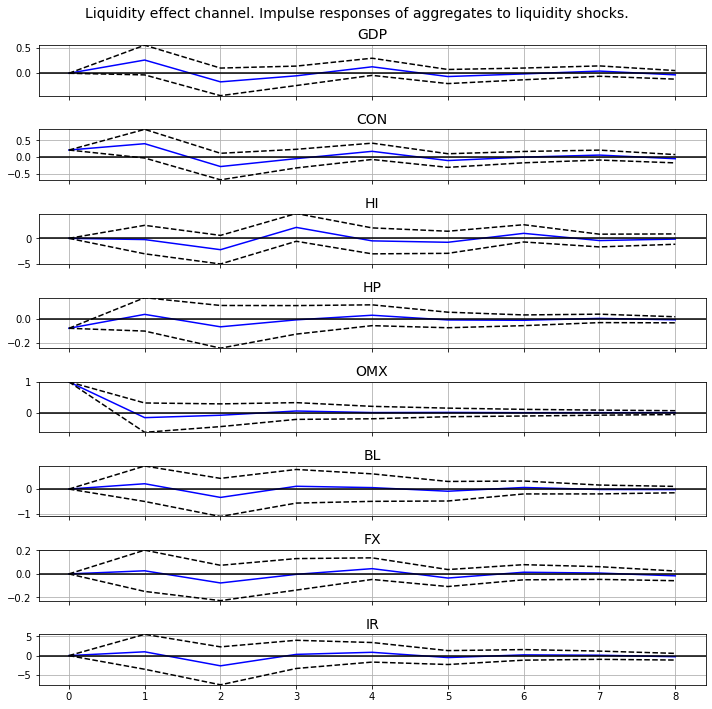

In [21]:
# Get the list of variable names in the model
var_names = ['GDP', 'CON', 'HI', 'HP', 'OMX', 'BL', 'FX', 'IR']

# Find the index of 't_bills' in this list
impulse_index = var_names.index('OMX')

# Use this index for the impulse parameter
irf = result.irf(periods=8)

# Create a figure with multiple subplots
fig = irf.plot(impulse=impulse_index, plot_stderr=True, subplot_params={'figsize': (10, 20)})

# Loop over the axes and set the title
for i, ax in enumerate(fig.axes):
    ax.set_title(f'{var_names[i]}', fontsize=14)
    ax.grid(True)
    ax.autoscale(enable=True, axis='y', tight=True)  # Automatically adjust y-axis limits

# Set the overall title
fig.suptitle('Liquidity effect channel. Impulse responses of aggregates to liquidity shocks.', fontsize=14)

plt.tight_layout()
plt.show()

In [22]:
# Get the impulse responses for all periods
irfs = irf.irfs

# Convert the array into a DataFrame
df = pd.DataFrame(irfs[:, impulse_index, :], columns=var_names)

# Set the index to be the periods
df.index.name = 'Period'

# Display the DataFrame with a title
print("Liquidity Effect channel. Impulse responses of aggregates to interest rate shock.")
display(df)


Liquidity Effect channel. Impulse responses of aggregates to interest rate shock.


,GDP,CON,HI,HP,OMX,BL,FX,IR
Period,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1,2.153187,-1.430172,0.028079,-0.042804,0.134685,-0.120946,0.586239,-0.030859
2,0.077576,0.108372,0.012441,0.105562,-0.101477,-0.065839,-0.497347,-0.003602
3,-0.508670,0.326593,-0.003880,0.041467,-0.015060,-0.014220,0.201074,-0.005817
4,-0.182742,0.073521,-0.008472,-0.136430,-0.025514,0.070469,-0.049858,0.008593
5,0.062625,-0.044445,-0.000494,0.006540,0.014951,-0.010777,-0.000913,0.002714
6,0.101036,-0.060395,0.002593,0.031536,0.011910,-0.001739,0.026743,-0.003148
7,0.010862,-0.002969,0.001150,0.002269,-0.001263,-0.013299,-0.028170,0.000239
8,-0.020496,0.014343,-0.000923,0.000661,-0.004712,0.006712,0.018008,-0.000939
